In [1]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import pingouin as pg

df = pd.read_csv('data/survey_results_public.csv')

##
## Stop outs from using scientific notation
##
pd.set_option('display.float_format', '{:.6f}'.format)

##
## Filtering responses which are not professional software developers in USA, UK or Germany that provided compensation information
##
df.dropna(subset=['CompTotal'], inplace=True)
df = df[df['MainBranch'] == 'I am a developer by profession']
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['Currency'].isin(['EUR European Euro', 'USD\tUnited States dollar', 'GBP\tPound sterling'])]
df = df[df[['Currency', 'Country']].apply(tuple, axis=1).isin([('USD\tUnited States dollar', 'United States of America'), ('EUR European Euro', 'Germany'), ('GBP\tPound sterling', 'United Kingdom of Great Britain and Northern Ireland')])]
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['DevType'].str.contains('Developer', na=False)]

##
## Drop columns which are not used
##

df = df[['EdLevel',
         'LearnCode', 
         'LearnCodeOnline', 
         'YearsCode', 
         'YearsCodePro', 
         'DevType', 
         'Country', 
         'LanguageHaveWorkedWith', 
         # 'LanguageWantToWorkWith', 
         'PlatformHaveWorkedWith', 
         # 'PlatformWantToWorkWith',
         'WebframeHaveWorkedWith', 
         # 'WebframeWantToWorkWith', 
         'EmbeddedHaveWorkedWith', 
         # 'EmbeddedWantToWorkWith', 
         'MiscTechHaveWorkedWith', 
         # 'MiscTechWantToWorkWith', 
         'ToolsTechHaveWorkedWith', 
         # 'ToolsTechWantToWorkWith', 
         'WorkExp', 
         'ConvertedCompYearly']]

##
## Break the "HaveWorkdWith" and "WantToWorkWith" columns down into a column for each language
##

WorkWithList = [
    'LanguageHaveWorkedWith', 
    # 'LanguageWantToWorkWith', 
    'PlatformHaveWorkedWith', 
    # 'PlatformWantToWorkWith',
    'WebframeHaveWorkedWith', 
    # 'WebframeWantToWorkWith', 
    'EmbeddedHaveWorkedWith', 
    # 'EmbeddedWantToWorkWith', 
    'MiscTechHaveWorkedWith', 
    # 'MiscTechWantToWorkWith', 
    'ToolsTechHaveWorkedWith', 
    # 'ToolsTechWantToWorkWith'
]

for WorkWith in WorkWithList:
    df_workwith = df[WorkWith].str.get_dummies(sep=';')
    df_workwith = df_workwith.add_prefix(WorkWith + '_')
    df = pd.concat([df, df_workwith], axis=1)

##
## Set a numerical value for each education level
##

# education_mapping = {
#     'Primary/elementary school': 1,
#     'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2,
#     'Some college/university study without earning a degree': 3,
#     'Associate degree (A.A., A.S., etc.)': 4,
#     'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5,
#     'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 6,
#     'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 7
# }
# df['EdLevelNumeric'] = df['EdLevel'].map(education_mapping)

df_edulevel = pd.get_dummies(df['EdLevel'], prefix='EdLevel', columns=['primary', 'secondary', 'partialuni', 'associate', 'bachelor', 'master', 'professional'])

df_edulevel = df_edulevel.astype(int)

df_edulevel = df_edulevel.rename(columns={
    'EdLevel_Primary/elementary school': 'EdLevel_primary',
    'EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'EdLevel_secondary',
    'EdLevel_Some college/university study without earning a degree': 'EdLevel_partialuni',
    'EdLevel_Associate degree (A.A., A.S., etc.)': 'EdLevel_associate',
    'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'EdLevel_bachelor',
    'EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'EdLevel_master',
    'EdLevel_Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 'EdLevel_professional'
})

df_edulevel.loc[df_edulevel['EdLevel_professional'] == 1, 'EdLevel_master'] = 1
df_edulevel.loc[df_edulevel['EdLevel_master'] == 1, 'EdLevel_bachelor'] = 1
df_edulevel.loc[df_edulevel['EdLevel_bachelor'] == 1, 'EdLevel_associate'] = 1
df_edulevel.loc[df_edulevel['EdLevel_associate'] == 1, 'EdLevel_partialuni'] = 1
df_edulevel.loc[df_edulevel['EdLevel_partialuni'] == 1, 'EdLevel_secondary'] = 1
df_edulevel.loc[df_edulevel['EdLevel_secondary'] == 1, 'EdLevel_primary'] = 1

df = pd.concat([df, df_edulevel], axis=1)

##
## Drop known bad cols which contain very little to no data
##

cols_to_drop = [
    # 'PlatformWantToWorkWith_PythonAnywhere', 
    # 'WebframeWantToWorkWith_Yii 2', 
    'EmbeddedHaveWorkedWith_CUTE'
]
df = df.drop(columns=cols_to_drop)

##
## Create a dataframe per country
##

df_GER = df[df['Country'] == 'Germany']
df_UK  = df[df['Country'] == 'United Kingdom of Great Britain and Northern Ireland']
df_USA = df[df['Country'] == 'United States of America']


##
## Remove Non Numeric Columns
##
df_GER = df_GER.select_dtypes(include='number')
df_UK  = df_UK.select_dtypes(include='number')
df_USA = df_USA.select_dtypes(include='number')


In [2]:
##
## Perform a partical correlation between each variable and Total Compensation.
##

dependent = 'ConvertedCompYearly'

corr_array_list = []
for country, df in [["GER",df_GER], ["UK", df_UK], ["USA",df_USA]]:

    independent_list = df.columns.tolist()
    independent_list.remove(dependent)

    array = pd.DataFrame()
    for independent in independent_list:

        corr = pg.partial_corr(data=df, 
                               x=independent, 
                               y=dependent, 
                               method='spearman')
        corr.index.values[0] = independent
        array = pd.concat([array, corr])

    array = array.add_prefix(country + '_')
    corr_array_list.append(array)

corr_df = pd.concat(corr_array_list, axis=1)

corr_df['AVG_r'] = corr_df[['GER_r', 'USA_r', 'UK_r']].mean(axis=1)
corr_df['AVG_p-val'] = corr_df[['GER_p-val', 'USA_p-val', 'UK_p-val']].mean(axis=1)
corr_df = corr_df.sort_values(by='AVG_r', ascending=False)

display(corr_df)

corr_df.to_csv('calculated_correlations.csv')


/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:877: RuntimeWarning: invalid value encountered in divide
  / np.sqrt(np.abs(Vi_diag - Vi**2 / Vi_diag[..., None])).T
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  #

,GER_n,GER_r,GER_CI95%,GER_p-val,UK_n,UK_r,UK_CI95%,UK_p-val,USA_n,USA_r,USA_CI95%,USA_p-val,AVG_r,AVG_p-val
WorkExp,905,0.514256,"[0.46, 0.56]",0.000000,671,0.412203,"[0.35, 0.47]",0.000000,2291,0.382118,"[0.35, 0.42]",0.000000,0.436192,0.000000
PlatformHaveWorkedWith_Amazon Web Services (AWS),1202,0.201221,"[0.15, 0.25]",0.000000,921,0.186091,"[0.12, 0.25]",0.000000,3102,0.194690,"[0.16, 0.23]",0.000000,0.194001,0.000000
EdLevel_master,1202,0.315944,"[0.26, 0.37]",0.000000,921,0.133310,"[0.07, 0.2]",0.000049,3102,0.130262,"[0.1, 0.16]",0.000000,0.193172,0.000016
ToolsTechHaveWorkedWith_Terraform,1202,0.198164,"[0.14, 0.25]",0.000000,921,0.167319,"[0.1, 0.23]",0.000000,3102,0.183067,"[0.15, 0.22]",0.000000,0.182850,0.000000
ToolsTechHaveWorkedWith_Kubernetes,1202,0.157696,"[0.1, 0.21]",0.000000,921,0.219061,"[0.16, 0.28]",0.000000,3102,0.157023,"[0.12, 0.19]",0.000000,0.177927,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LanguageHaveWorkedWith_JavaScript,1202,-0.196424,"[-0.25, -0.14]",0.000000,921,-0.116793,"[-0.18, -0.05]",0.000383,3102,-0.137608,"[-0.17, -0.1]",0.000000,-0.150275,0.000128
WebframeHaveWorkedWith_jQuery,1202,-0.153361,"[-0.21, -0.1]",0.000000,921,-0.151405,"[-0.21, -0.09]",0.000004,3102,-0.148428,"[-0.18, -0.11]",0.000000,-0.151065,0.000001
LanguageHaveWorkedWith_C#,1202,-0.123441,"[-0.18, -0.07]",0.000018,921,-0.178627,"[-0.24, -0.12]",0.000000,3102,-0.181555,"[-0.22, -0.15]",0.000000,-0.161208,0.000006
LanguageHaveWorkedWith_PHP,1202,-0.176109,"[-0.23, -0.12]",0.000000,921,-0.167646,"[-0.23, -0.1]",0.000000,3102,-0.149162,"[-0.18, -0.11]",0.000000,-0.164306,0.000000


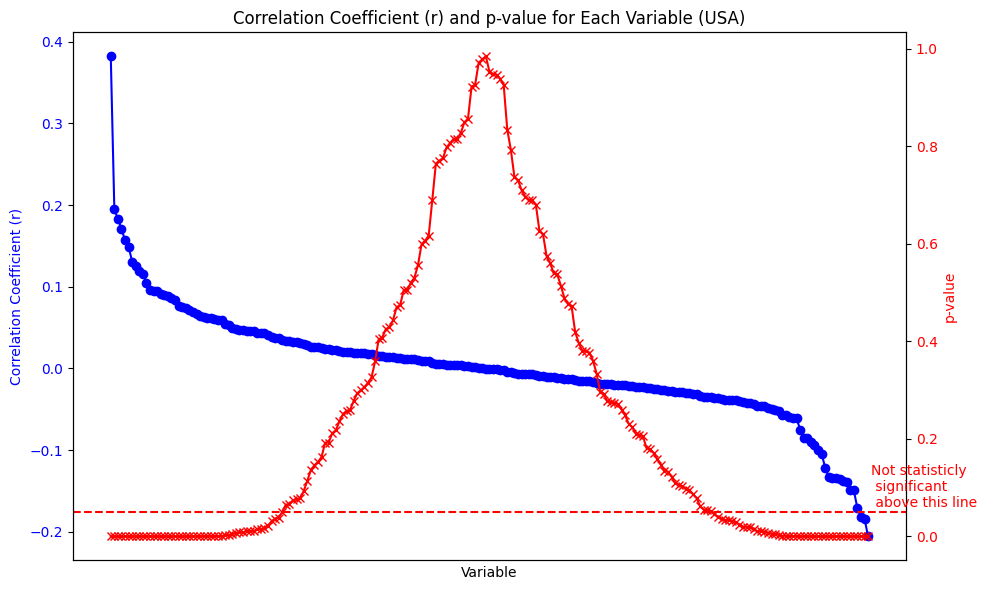

In [3]:
import matplotlib.pyplot as plt

corr_df = corr_df.sort_values(by='USA_r', ascending=False)

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Variable')
ax1.set_ylabel('Correlation Coefficient (r)', color='blue')
ax1.plot(corr_df.index, corr_df['USA_r'], marker='o', color='blue', label='r')
ax1.tick_params(axis='y', labelcolor='blue')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)


ax2 = ax1.twinx() 
ax2.set_ylabel('p-value', color='red')
ax2.plot(corr_df.index, corr_df['USA_p-val'], marker='x', color='red', label='p-val')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=0.05, color='red', linestyle='--', label='p-value cutoff (0.05)')
ax2.text(len(corr_df.index)-0.05, 0.05+0.01, 'Not statisticly \n significant \n above this line', color='red')

plt.title('Correlation Coefficient (r) and p-value for Each Variable (USA)')

# Display the plot
plt.tight_layout()
plt.savefig('randp.png', format='png')
plt.show()



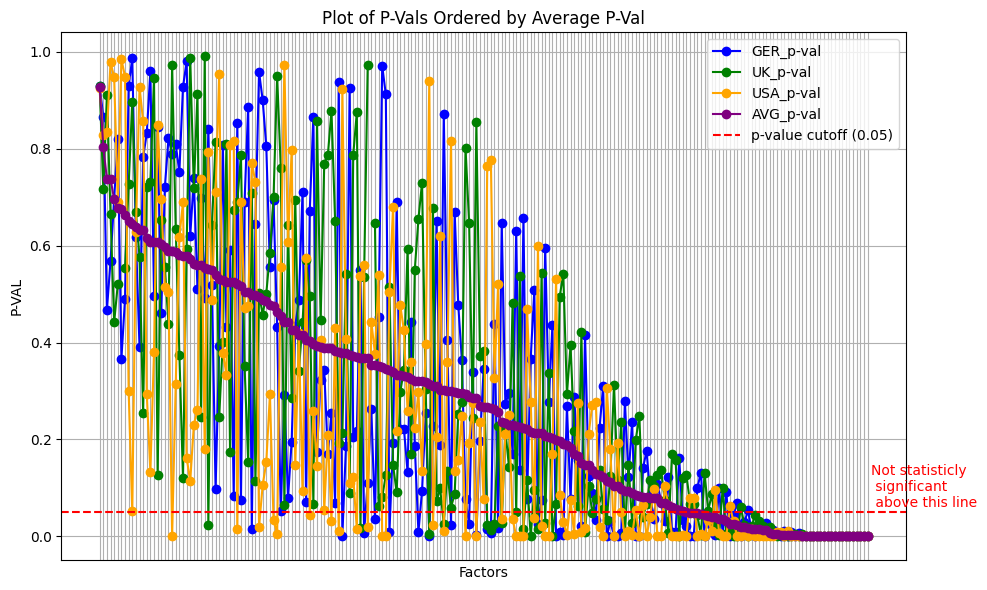

In [4]:
corr_df = corr_df.sort_values(by='AVG_p-val', ascending=False)

plt.figure(figsize=(10, 6))

plt.plot(corr_df.index, corr_df['GER_p-val'], marker='o', label='GER_p-val', color='blue')
plt.plot(corr_df.index, corr_df['UK_p-val'], marker='o', label='UK_p-val', color='green')
plt.plot(corr_df.index, corr_df['USA_p-val'], marker='o', label='USA_p-val', color='orange')
plt.plot(corr_df.index, corr_df['AVG_p-val'], marker='o', label='AVG_p-val', color='purple')

plt.axhline(y=0.05, color='red', linestyle='--', label='p-value cutoff (0.05)')
plt.text(len(corr_df.index)-0.05, 0.05+0.01, 'Not statisticly \n significant \n above this line', color='red')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

plt.xlabel('Factors')
plt.ylabel('P-VAL')
plt.title('Plot of P-Vals Ordered by Average P-Val')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('regionalpvalue.png', format='png')
plt.show()


In [5]:
corr_df_sig_all = corr_df.loc[((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05))]
corr_df_sig_all = corr_df_sig_all.drop(columns=['GER_n', 'UK_n', 'USA_n', 'GER_CI95%', 'UK_CI95%', 'USA_CI95%'])
corr_df_sig_all = corr_df_sig_all.sort_values(by='AVG_r', ascending=False)
display(corr_df_sig_all)

,GER_r,GER_p-val,UK_r,UK_p-val,USA_r,USA_p-val,AVG_r,AVG_p-val
WorkExp,0.514256,0.000000,0.412203,0.000000,0.382118,0.000000,0.436192,0.000000
PlatformHaveWorkedWith_Amazon Web Services (AWS),0.201221,0.000000,0.186091,0.000000,0.194690,0.000000,0.194001,0.000000
EdLevel_master,0.315944,0.000000,0.133310,0.000049,0.130262,0.000000,0.193172,0.000016
ToolsTechHaveWorkedWith_Terraform,0.198164,0.000000,0.167319,0.000000,0.183067,0.000000,0.182850,0.000000
ToolsTechHaveWorkedWith_Kubernetes,0.157696,0.000000,0.219061,0.000000,0.157023,0.000000,0.177927,0.000000
EdLevel_bachelor,0.283945,0.000000,0.158804,0.000001,0.088624,0.000001,0.177124,0.000001
EdLevel_associate,0.285089,0.000000,0.148694,0.000006,0.045865,0.010625,0.159883,0.003544
MiscTechHaveWorkedWith_Apache Kafka,0.125133,0.000014,0.163341,0.000001,0.149304,0.000000,0.145926,0.000005
EdLevel_partialuni,0.250223,0.000000,0.097982,0.002914,0.047313,0.008400,0.131839,0.003771
ToolsTechHaveWorkedWith_Homebrew,0.095859,0.000876,0.122910,0.000185,0.170613,0.000000,0.129794,0.000354


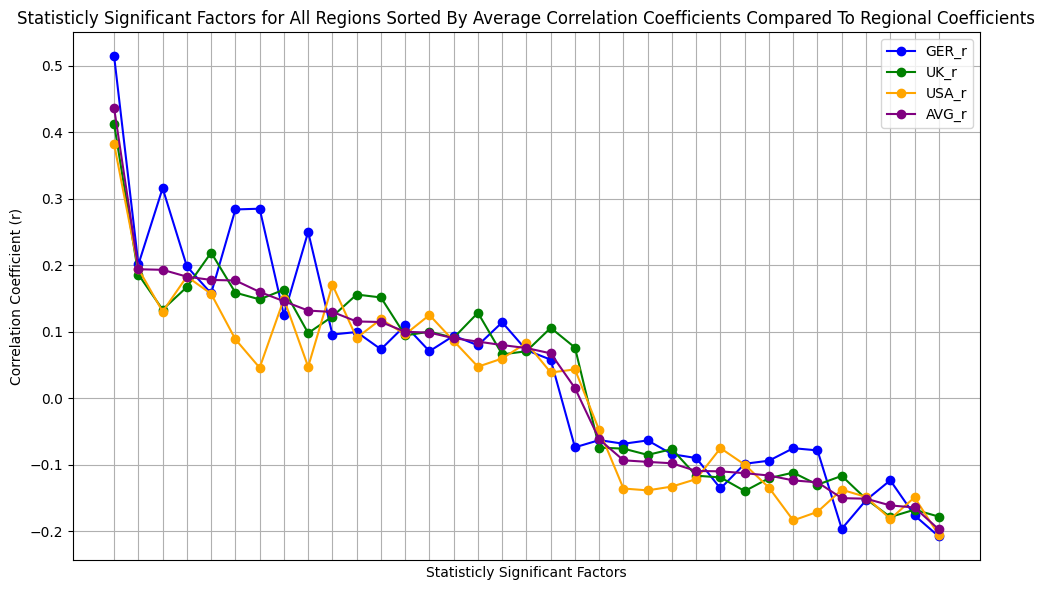

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(corr_df_sig_all.index, corr_df_sig_all['GER_r'], marker='o', label='GER_r', color='blue')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['UK_r'], marker='o', label='UK_r', color='green')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['USA_r'], marker='o', label='USA_r', color='orange')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['AVG_r'], marker='o', label='AVG_r', color='purple')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

plt.xlabel('Statisticly Significant Factors')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Statisticly Significant Factors for All Regions Sorted By Average Correlation Coefficients Compared To Regional Coefficients')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('siginallcoefficients.png', format='png')
plt.show()


In [7]:
corr_df_sig_all_avg_summary = corr_df_sig_all.drop(columns=['GER_r', 'UK_r', 'USA_r', 'GER_p-val', 'UK_p-val', 'USA_p-val'])
corr_df_sig_all_avg_summary = corr_df_sig_all_avg_summary.sort_values(by='AVG_r', ascending=False)
display(corr_df_sig_all_avg_summary)

,AVG_r,AVG_p-val
WorkExp,0.436192,0.000000
PlatformHaveWorkedWith_Amazon Web Services (AWS),0.194001,0.000000
EdLevel_master,0.193172,0.000016
ToolsTechHaveWorkedWith_Terraform,0.182850,0.000000
ToolsTechHaveWorkedWith_Kubernetes,0.177927,0.000000
EdLevel_bachelor,0.177124,0.000001
EdLevel_associate,0.159883,0.003544
MiscTechHaveWorkedWith_Apache Kafka,0.145926,0.000005
EdLevel_partialuni,0.131839,0.003771
ToolsTechHaveWorkedWith_Homebrew,0.129794,0.000354


In [8]:
corr_df_sig_ger = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05))]
corr_df_sig_ger = corr_df_sig_ger.loc[((corr_df['GER_p-val'] < 0.05))]
corr_df_sig_ger = corr_df_sig_ger.loc[((corr_df['GER_r'] > 0))]
corr_df_sig_ger = corr_df_sig_ger[['GER_r', 'GER_p-val']]
corr_df_sig_ger = corr_df_sig_ger.sort_values(by='GER_r', ascending=False)
display(corr_df_sig_ger)

,GER_r,GER_p-val
EdLevel_professional,0.141278,0.000001
ToolsTechHaveWorkedWith_Google Test,0.111460,0.000108
EdLevel_secondary,0.100089,0.000510
PlatformHaveWorkedWith_OpenStack,0.099453,0.000554
LanguageHaveWorkedWith_Elixir,0.098689,0.000612
EdLevel_primary,0.097732,0.000691
LanguageHaveWorkedWith_Perl,0.094216,0.001074
LanguageHaveWorkedWith_Ruby,0.093294,0.001203
WebframeHaveWorkedWith_Phoenix,0.089266,0.001950
PlatformHaveWorkedWith_Microsoft Azure,0.080532,0.005211


In [9]:
corr_df_sig_uk = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05))]
corr_df_sig_uk = corr_df_sig_uk.loc[((corr_df['UK_p-val'] < 0.05))]
corr_df_sig_uk = corr_df_sig_uk.loc[((corr_df['UK_r'] > 0))]
corr_df_sig_uk = corr_df_sig_uk[['UK_r', 'UK_p-val']]
corr_df_sig_uk = corr_df_sig_uk.sort_values(by='UK_r', ascending=False)
display(corr_df_sig_uk)

,UK_r,UK_p-val
ToolsTechHaveWorkedWith_Make,0.133135,0.000051
EmbeddedHaveWorkedWith_Catch2,0.127435,0.000105
EmbeddedHaveWorkedWith_Boost.Test,0.124523,0.000151
MiscTechHaveWorkedWith_Hadoop,0.097544,0.003044
LanguageHaveWorkedWith_Kotlin,0.096512,0.003370
ToolsTechHaveWorkedWith_Gradle,0.092395,0.005013
LanguageHaveWorkedWith_TypeScript,0.087204,0.008099
WebframeHaveWorkedWith_FastAPI,0.084739,0.010088
ToolsTechHaveWorkedWith_Ninja,0.082273,0.012501
LanguageHaveWorkedWith_OCaml,0.079605,0.015675


In [12]:
corr_df_sig_usa = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05))]
corr_df_sig_usa = corr_df_sig_usa.loc[((corr_df['USA_p-val'] < 0.05))]
corr_df_sig_usa = corr_df_sig_usa.loc[((corr_df['USA_r'] > 0))]
corr_df_sig_usa = corr_df_sig_usa[['USA_r', 'USA_p-val']]
corr_df_sig_usa = corr_df_sig_usa.sort_values(by='USA_r', ascending=False)
display(corr_df_sig_usa)

,USA_r,USA_p-val
LanguageHaveWorkedWith_Ruby,0.116040,0.000000
ToolsTechHaveWorkedWith_Make,0.105124,0.000000
WebframeHaveWorkedWith_Ruby on Rails,0.095317,0.000000
LanguageHaveWorkedWith_Elixir,0.094541,0.000000
LanguageHaveWorkedWith_Rust,0.090015,0.000001
WebframeHaveWorkedWith_Phoenix,0.076647,0.000019
LanguageHaveWorkedWith_Bash/Shell (all shells),0.075135,0.000028
LanguageHaveWorkedWith_Clojure,0.073833,0.000039
LanguageHaveWorkedWith_Kotlin,0.071282,0.000071
ToolsTechHaveWorkedWith_Yarn,0.069670,0.000103
